This notebook will first explore the VGG11 model with the MNIST dataset. Then, we will try to see the effect of training with augmented data in order to improve accuracies. 

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim

In [85]:
# load data and resize
mnist_trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=torchvision.transforms.Compose(
        [torchvision.transforms.Resize(32), torchvision.transforms.ToTensor()]),)
mnist_testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=torchvision.transforms.Compose(
        [torchvision.transforms.Resize(32), torchvision.transforms.ToTensor()]),)

train_loader = torch.utils.data.DataLoader(mnist_trainset, batch_size=1028)
test_loader = torch.utils.data.DataLoader(mnist_testset, batch_size=1028)

In [86]:
# define the VGG11 network
class VGG11(nn.Module):
    def __init__(self):
        super(VGG11, self).__init__()
        # convolutional layers 
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # fully connected layers
        self.linear_layers = nn.Sequential(
            nn.Linear(512, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 10)
        )
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = torch.flatten(x, 1)
        x = self.linear_layers(x)
        return x

In [131]:
model = VGG11()
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
training_accuracy, training_loss, test_accuracy, test_loss = [], [], [], []


def test():
    model.eval()
    loss_sum = 0
    n_correct = 0
    with torch.no_grad():
        for x, y in test_loader:
            output = model(x)
            loss = loss_func(output, y)
            loss_sum += loss.item()
            _, pred = torch.max(output.data, 1)
            n_correct += (pred == y).sum().item()
    avg_loss = loss_sum/len(test_loader)
    acc = n_correct/len(test_loader.dataset)
    print("test accuracy: {:.4f}".format(acc))
    print("test loss: {:.4f}".format(avg_loss))
    test_accuracy.append(acc)
    test_loss.append(avg_loss)


def train(loader):
    n_correct = 0
    loss_sum = 0
    model.train()
    batch_size = len(loader)
    for i, (x, y) in enumerate(loader):
        optimizer.zero_grad()
        output = model(x)

        loss = loss_func(output, y)
        loss.backward()
        optimizer.step()

        _, pred = torch.max(output.data, 1)
        n_correct += (pred == y).sum().item()
        loss_sum += loss.item()
        if (i+1)%10==0:
            print ('Batch [{}/{}], Loss: {:.4f}'.format(i + 1, batch_size, loss.item()))
    # calculate training loss and accuracy 
    acc = n_correct/len(loader.dataset)
    avg_loss = loss_sum/batch_size
    print("training accuracy: {:.4f}".format(acc))
    print("training loss: {:.4f}".format(avg_loss))
    training_accuracy.append(acc)
    training_loss.append(avg_loss)
    

def run_model(epoch):
    for i in range(epoch):
        print("Epoch [{}/{}]".format(i+1, epoch))
        train(train_loader)
        test()


In [ ]:

run_model(5)

In [91]:
torch.save({
            'epoch': 5,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss_func,
            }, '../A3/model.pth')

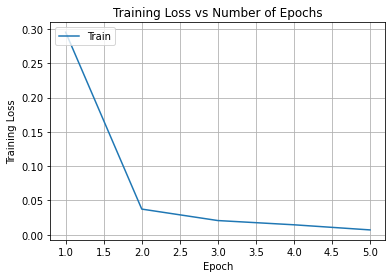

In [96]:
epochs_x = [1,2,3,4,5]
# plot training loss
plt.plot(epochs_x, training_loss)
plt.title('Training Loss vs Number of Epochs')
plt.ylabel('Training Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.grid()
plt.show()

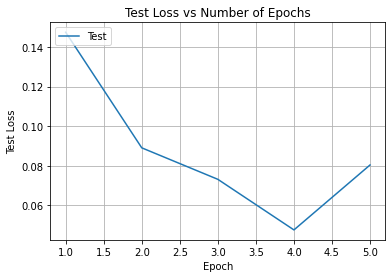

In [97]:
# plot training loss
plt.plot(epochs_x, test_loss)
plt.title('Test Loss vs Number of Epochs')
plt.ylabel('Test Loss')
plt.xlabel('Epoch')
plt.legend(['Test'], loc='upper left')
plt.grid()
plt.show()

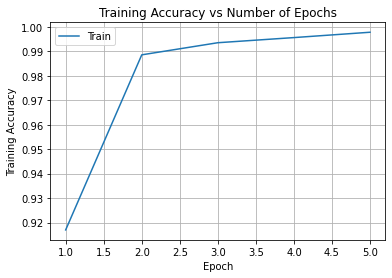

In [98]:
plt.plot(epochs_x, training_accuracy)
plt.title('Training Accuracy vs Number of Epochs')
plt.ylabel('Training Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.grid()
plt.show()

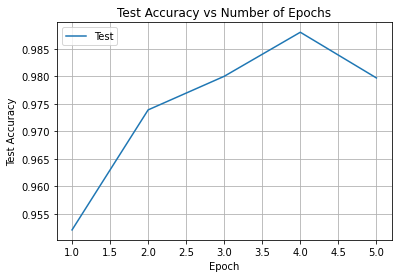

In [99]:
plt.plot(epochs_x, test_accuracy)
plt.title('Test Accuracy vs Number of Epochs')
plt.ylabel('Test Accuracy')
plt.xlabel('Epoch')
plt.legend(['Test'], loc='upper left')
plt.grid()
plt.show()

First, flip the training images vertically and horizontally and test the model

In [4]:
# load data,  resize, and flip
test_flip_vert = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=torchvision.transforms.Compose(
        [torchvision.transforms.Resize(32), torchvision.transforms.ToTensor(),torchvision.transforms.RandomVerticalFlip(p=1)]),)
test_flip_hori = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=torchvision.transforms.Compose(
        [torchvision.transforms.Resize(32), torchvision.transforms.ToTensor(),torchvision.transforms.RandomHorizontalFlip(p=1)]),)

vert_loader = torch.utils.data.DataLoader(test_flip_vert, batch_size=1028)
hori_loader = torch.utils.data.DataLoader(test_flip_hori, batch_size=1028)

In [ ]:
model.eval()
def test_transformed(loader):
    loss_sum = 0
    n_correct = 0
    with torch.no_grad():
        for x, y in loader:
            output = model(x)
            loss = loss_func(output, y)
            loss_sum += loss.item()
            _, pred = torch.max(output.data, 1)
            n_correct += (pred == y).sum().item()
    avg_loss = loss_sum/len(loader)
    acc = n_correct/len(loader.dataset)
    print("test accuracy: {:.4f}".format(acc))
    print("test loss: {:.4f}".format(avg_loss))

In [101]:
# horizontally flipped
test_transformed(hori_loader)
# vertical flipped
test_transformed(vert_loader)

test accuracy: 0.3968
test loss: 6.3348
test accuracy: 0.4090
test loss: 5.7250


Next, add gaussian noise with different variances to the training images and test the model. 

In [112]:
# Gaussian noise
test_blur_100 = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=torchvision.transforms.Compose(
        [torchvision.transforms.Resize(32),
         torchvision.transforms.ToTensor(),
         torchvision.transforms.Lambda(lambda x : x + 0.01*torch.randn_like(x))]),)
test_blur_10 = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=torchvision.transforms.Compose(
        [torchvision.transforms.Resize(32),
         torchvision.transforms.ToTensor(),
         torchvision.transforms.Lambda(lambda x : x + 0.1*torch.randn_like(x))]),)
test_blur_1 = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=torchvision.transforms.Compose(
        [torchvision.transforms.Resize(32),
         torchvision.transforms.ToTensor(),
         torchvision.transforms.Lambda(lambda x : x + 1*torch.randn_like(x))]),)

blur_1_loader = torch.utils.data.DataLoader(test_blur_1, batch_size=1028)
blur_10_loader = torch.utils.data.DataLoader(test_blur_10, batch_size=1028)
blur_100_loader = torch.utils.data.DataLoader(test_blur_100, batch_size=1028)

In [113]:
print("Gaussian Noise with variance 1:")
test_transformed(blur_1_loader)
print("-----")
print("Gaussian Noise with variance 0.1:")
test_transformed(blur_10_loader)
print("-----")
print("Gaussian Noise with variance 0.01:")
test_transformed(blur_100_loader)

Gaussian Noise with variance 1:
test accuracy: 0.0974
test loss: 46.7309
-----
Gaussian Noise with variance 0.1:
test accuracy: 0.9008
test loss: 0.4538
-----
Gaussian Noise with variance 0.01:
test accuracy: 0.9804
test loss: 0.0779


The test accuracies for flipped and blurred images are significantly lower. Now, to improve these accuracies, we can train the model with augmented data. 

In [133]:
from torch.utils.data import ConcatDataset

updated_train = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=torchvision.transforms.Compose(
        [torchvision.transforms.Resize(32),
         torchvision.transforms.RandomHorizontalFlip(0.3),
         torchvision.transforms.RandomVerticalFlip(0.3),
         torchvision.transforms.ToTensor()
         ]),)

blurred_train = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=torchvision.transforms.Compose(
    [torchvision.transforms.Resize(32),
     torchvision.transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 1.)),
     torchvision.transforms.ToTensor()
     ]),)


blurred_train_subset, garbage = torch.utils.data.random_split(blurred_train, [15000, 45000])
augmented_train = ConcatDataset([updated_train,blurred_train_subset])

training_accuracy, training_loss, test_accuracy, test_loss = [], [], [], []
augmented_train_loader = torch.utils.data.DataLoader(augmented_train, batch_size=1028)

In [135]:
def run_augmented(epoch):
    for i in range(epoch):
        print("Epoch [{}/{}]".format(i+1, epoch))
        train(augmented_train_loader)

run_augmented(3)
print("Horizontally flipped:")
test_transformed(hori_loader)
print("-----")
print("Vertically flipped:")
test_transformed(vert_loader)
print("-----")
print("Gaussian Noise with variance 1:")
test_transformed(blur_1_loader)
print("-----")
print("Gaussian Noise with variance 0.1:")
test_transformed(blur_10_loader)
print("-----")
print("Gaussian Noise with variance 0.01:")
test_transformed(blur_100_loader)

Epoch [1/3]
Batch [10/73], Loss: 0.0553
Batch [20/73], Loss: 0.0693
Batch [30/73], Loss: 0.0662
Batch [40/73], Loss: 0.0659
Batch [50/73], Loss: 0.0748
Batch [60/73], Loss: 0.0497
Batch [70/73], Loss: 0.0226
training accuracy: 0.9802
training loss: 0.0629
Epoch [2/3]
Batch [10/73], Loss: 0.0620
Batch [20/73], Loss: 0.0636
Batch [30/73], Loss: 0.0712
Batch [40/73], Loss: 0.0520
Batch [50/73], Loss: 0.0675
Batch [60/73], Loss: 0.0373
Batch [70/73], Loss: 0.0072
training accuracy: 0.9805
training loss: 0.0629
Epoch [3/3]
Batch [10/73], Loss: 0.0554
Batch [20/73], Loss: 0.0563
Batch [30/73], Loss: 0.0530
Batch [40/73], Loss: 0.0368
Batch [50/73], Loss: 0.0384
Batch [60/73], Loss: 0.0321
Batch [70/73], Loss: 0.0095
training accuracy: 0.9833
training loss: 0.0526
Horizontally flipped:
test accuracy: 0.9120
test loss: 0.3495
-----
Vertically flipped:
test accuracy: 0.9028
test loss: 0.3852
-----
Gaussian Noise with variance 1:
test accuracy: 0.3334
test loss: 3.3060
-----
Gaussian Noise with 

We can see that the accuracies have increased greatly with augmented data training. 

In [136]:
torch.save({
            'epoch': 3,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss_func,
            }, '../A3/augmented_model.pth')